# Our QR

Rank of the original image: 512
Stopping at column 498 because R[498,498] = -4.92e-02 is below the tolerance 0.05
Took 2.58461595 seconds to perform QR decomposition
PSNR: 61.27768874996108
Truncated to rank: 499


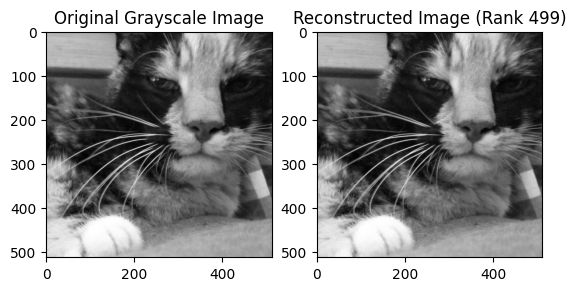

In [39]:
import imageio as iio
import numpy as np
from matplotlib import pyplot
from skimage import color
import time
from skimage.metrics import peak_signal_noise_ratio as psnr

import factorizations as fct
from PIL import Image
import cv2

def display_image(matrix):
    """Display a 2D NumPy array as a black and white image."""
    pyplot.imshow(matrix, cmap='gray', interpolation='nearest')
    pyplot.colorbar()  # Optionally add a colorbar to show the mapping from data values to colors
    pyplot.show()

img = color.rgb2gray(iio.v3.imread('imageio:wikkie.png'))

original_rank = np.linalg.matrix_rank(img)
print("Rank of the original image:", original_rank)

A = img

def householder_reflection(a):
    """Create a Householder reflection that zeroes all but the first component of a."""
    v = a.copy()
    v[0] += np.sign(a[0]) * np.linalg.norm(a)
    v = v / np.linalg.norm(v)
    H = np.eye(len(v)) - 2 * np.outer(v, v)
    return H

def qr_rank_revealing(A, tol):

    """Perform a rank-revealing QR factorization using Householder reflections."""
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()
    
    for k in range(min(m, n)):
        Hk = np.eye(m)
        Hk[k:, k:] = householder_reflection(R[k:, k])
        R = np.dot(Hk, R)
        Q = np.dot(Q, Hk.T)


        # if int(time.time()) % 5 == 0:
            #print(f"Checking R[{k},{k}] = {abs(R[k,k]):.2e}")

        if abs(R[k, k]) < tol:
            print(f"Stopping at column {k} because R[{k},{k}] = {R[k,k]:.2e} is below the tolerance {tol}")
            break
    
    return Q, R[:k+1, :], k+1


start_qr_time = time.time()


Q, R, RANK = qr_rank_revealing(A, 0.05)

Q = Q[:, :RANK]

end_qr_time = time.time()



print('Took {:.8f} seconds to perform QR decomposition'.format(end_qr_time - start_qr_time))

img_reconstructed = Q @ R

# Display the original grayscale image
pyplot.subplot(1, 2, 1)
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.title('Original Grayscale Image')

# Display the reconstructed image
pyplot.subplot(1, 2, 2)
pyplot.imshow(img_reconstructed, cmap=pyplot.cm.gray)
pyplot.title('Reconstructed Image (Rank {})'.format(RANK))

# Calculate the PSNR
print("PSNR:", psnr(img, img_reconstructed))
print("Truncated to rank:", RANK)

pyplot.show()

In [41]:
# create list 0.05,0.1,0.15,...,0.5
tols = np.arange(0.05, 0.55, 0.05)

psnrs_from_tols = []
times_from_tols = []
ranks_from_tols = []

for tol in tols:

    start_rrqr_time = time.time()

    Q, R, RANK = qr_rank_revealing(A, tol)

    stop_rrqr_time = time.time()

    times_from_tols.append(stop_rrqr_time - start_rrqr_time)

    Q = Q[:, :RANK]
    img_reconstructed = Q @ R
    psnrs_from_tols.append(psnr(img, img_reconstructed))
    ranks_from_tols.append(RANK)

print("Tolerances:", tols)
print("Ranks from different tolerances:", ranks_from_tols)
print("PSNRs from different tolerances:", psnrs_from_tols)

Stopping at column 498 because R[498,498] = -4.92e-02 is below the tolerance 0.05
Stopping at column 483 because R[483,483] = -8.40e-02 is below the tolerance 0.1
Stopping at column 419 because R[419,419] = 1.43e-01 is below the tolerance 0.15000000000000002
Stopping at column 380 because R[380,380] = -1.94e-01 is below the tolerance 0.2
Stopping at column 334 because R[334,334] = 2.29e-01 is below the tolerance 0.25
Stopping at column 311 because R[311,311] = 2.78e-01 is below the tolerance 0.3
Stopping at column 292 because R[292,292] = -3.45e-01 is below the tolerance 0.35000000000000003
Stopping at column 289 because R[289,289] = -3.97e-01 is below the tolerance 0.4
Stopping at column 26 because R[26,26] = 4.38e-01 is below the tolerance 0.45
Stopping at column 1 because R[1,1] = 4.52e-01 is below the tolerance 0.5
Tolerances: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
Ranks from different tolerances: [499, 484, 420, 381, 335, 312, 293, 290, 27, 2]
PSNRs from different tol

Rank of the original image: 512
Took 0.00019598 seconds to perform QR decomposition
PSNR: 29.541370403233827
Truncated to rank: 293


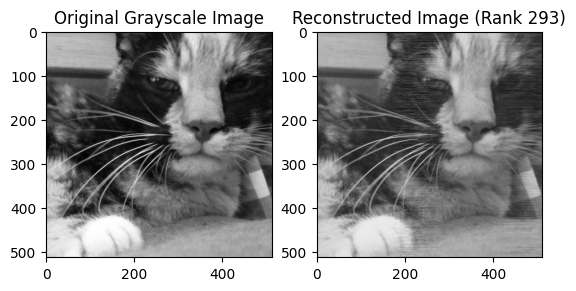

In [45]:
import imageio as iio
import numpy as np
from matplotlib import pyplot
from skimage import color
import time
from skimage.metrics import peak_signal_noise_ratio as psnr

import factorizations as fct
from PIL import Image
import cv2


# ====== PARAMATERS ======

# Set rank for the low-rank approximation
RANK = 293

# ====== SETUP ======

# Load the image, set greyscale, and resize
img = color.rgb2gray(iio.v3.imread('imageio:wikkie.png'))

original_rank = np.linalg.matrix_rank(img)
print("Rank of the original image:", original_rank)


# ====== QR DECOMPOSITION ======

A = img

def householder_reflection(a):
    """Create the Householder matrix that will zero out the sub-diagonal elements of matrix a."""
    v = a.copy()
    v[0] += np.sign(a[0]) * np.linalg.norm(a)
    v = v / np.linalg.norm(v)
    H = np.eye(len(a)) - 2 * np.outer(v, v)
    return H


start_qr_time = time.time()


def full_qr(A):

    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()
    P = np.eye(n)

    for i in range(RANK):
        # Pivoting based on the maximum norm of remaining columns
        max_col = np.argmax(np.linalg.norm(R[:, i:], axis=0)) + i
        P[:, [i, max_col]] = P[:, [max_col, i]]
        R[:, [i, max_col]] = R[:, [max_col, i]]

        # Apply Householder reflection
        H = np.eye(m)
        H[i:, i:] = householder_reflection(R[i:, i])
        R = H @ R
        Q = Q @ H.T

    return Q, R, P

end_qr_time = time.time()


Q,R,P = full_qr(A)


print('Took {:.8f} seconds to perform QR decomposition'.format(end_qr_time - start_qr_time))



# ====== TRUNCATION AND RECONSTRUCTION ======
R_permuted = R @ P.T
Q_truncated = Q[:, :RANK]
R_truncated = R_permuted[:RANK, :]
img_reconstructed = Q_truncated @ R_truncated

# Display the original grayscale image
pyplot.subplot(1, 2, 1)
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.title('Original Grayscale Image')

# Display the reconstructed image
pyplot.subplot(1, 2, 2)
pyplot.imshow(img_reconstructed, cmap=pyplot.cm.gray)
pyplot.title('Reconstructed Image (Rank {})'.format(RANK))

# Calculate the PSNR
print("PSNR:", psnr(img, img_reconstructed))
print("Truncated to rank:", RANK)

pyplot.show()

In [47]:
times_qr = []


for i in 100:

    start_qr_time = time.time()

    Q,R,P = full_qr(A)

    stop_qr_time = time.time()

    times_qr.append(stop_qr_time - start_qr_time)
    
    R_permuted = R @ P.T

avg_qr_time = np.mean(times_qr)



pyplot.plot(rank_list, psnrs_from_ranks)

Ranks: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245

# NumPy QR

Took 0.04914618 seconds to perform QR decomposition
PSNR: 17.80012758997756
Truncated to rank: 100


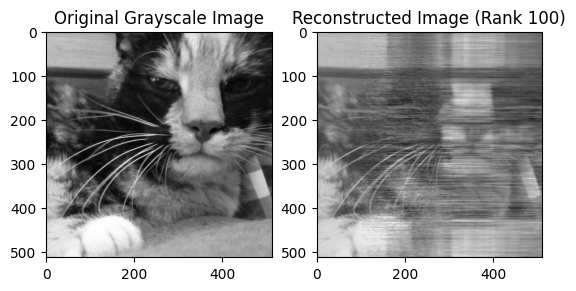

In [20]:
start_qr_time = time.time()
# Perform QR decomposition
Q, R = np.linalg.qr(img)
end_qr_time = time.time()

print('Took {:.8f} seconds to perform QR decomposition'.format(end_qr_time - start_qr_time))

# Choose a rank to approximate the image
rank = 100

# Truncate Q and R to the chosen rank
Q_truncated = Q[:, :rank]
R_truncated = R[:rank, :]

# Reconstruct the image using the truncated matrices
img_reconstructed = Q_truncated @ R_truncated

# Display the original grayscale image
pyplot.subplot(1, 2, 1)
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.title('Original Grayscale Image')

# Display the reconstructed image
pyplot.subplot(1, 2, 2)
pyplot.imshow(img_reconstructed, cmap=pyplot.cm.gray)
pyplot.title('Reconstructed Image (Rank {})'.format(rank))

# Calculate the PSNR
print("PSNR:", psnr(img, img_reconstructed))
print("Truncated to rank:", RANK)

pyplot.show()

psnr_list_qr = []
bytes_list_qr = []

for this_rank in range(10,512):
    Q_truncated = Q[:, :this_rank]
    R_truncated = R[:this_rank, :]
    img_reconstructed = Q_truncated @ R_truncated
    
    this_psnr = psnr(img, img_reconstructed)

    psnr_list_qr.append(this_psnr)

    #buffer = BytesIO()
    #tifffile.imwrite(buffer, img_reconstructed, dtype='float64')

    # Rewind the buffer to the start
    #buffer.seek(0)

    # Get the number of bytes
    #num_bytes = len(buffer.getvalue())
    #bytes_list_qr.append(num_bytes)
    #print(f"The estimated number of bytes to store the image as a PNG is: {num_bytes} bytes")

SVD decomposition took 0.06708789 seconds
47.60346775951123


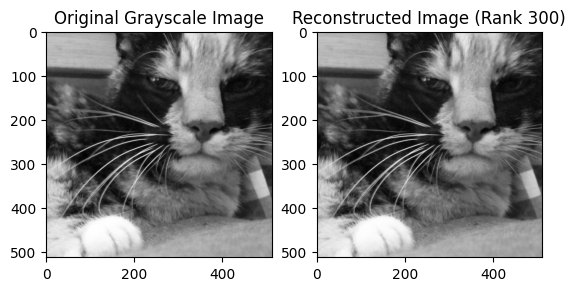

NameError: name 'BytesIO' is not defined

In [26]:
# Start timing for SVD decomposition
start_svd_time = time.time()

# Perform SVD decomposition
U, S, Vt = np.linalg.svd(img, full_matrices=False)

end_svd_time = time.time()
print("SVD decomposition took {:.8f} seconds".format(end_svd_time - start_svd_time))

rank = 300

# Use only the top 'rank' singular values and corresponding vectors
U_truncated = U[:, :rank]
S_truncated = np.diag(S[:rank])
Vt_truncated = Vt[:rank, :]

# Reconstruct the image using the truncated matrices
img_reconstructed = U_truncated @ S_truncated @ Vt_truncated

# Display the original grayscale image
pyplot.subplot(1, 2, 1)
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.title('Original Grayscale Image')

# Display the reconstructed image
pyplot.subplot(1, 2, 2)
pyplot.imshow(img_reconstructed, cmap=pyplot.cm.gray)
pyplot.title('Reconstructed Image (Rank {})'.format(rank))

print(psnr(img, img_reconstructed))

pyplot.show()

psnr_list_svd = []
bytes_list_svd = []

for this_rank in range(10,512):
    U_truncated = U[:, :this_rank]
    S_truncated = np.diag(S[:this_rank])
    Vt_truncated = Vt[: this_rank, :]
    img_reconstructed = U_truncated @ S_truncated @ Vt_truncated
    this_psnr = psnr(img, img_reconstructed)

    psnr_list_svd.append(this_psnr)

    buffer = BytesIO()
    tifffile.imwrite(buffer, img_reconstructed, dtype='float64')

    # Rewind the buffer to the start
    buffer.seek(0)

    # Get the number of bytes
    num_bytes = len(buffer.getvalue())
    bytes_list_svd.append(num_bytes)

rank_list = np.arange(10, 512)

buffer = BytesIO()
tifffile.imwrite(buffer, img, dtype='float64')

# Rewind the buffer to the start
buffer.seek(0)

# Get the number of bytes
num_bytes_original = len(buffer.getvalue())

ratio_list_svd = [i / num_bytes_original for i in bytes_list_svd]
ratio_list_qr = [i / num_bytes_original for i in bytes_list_qr]


# Create a plot
pyplot.figure(figsize=(8, 5))

print(rank_list)

print(psnr_list_qr)
print(psnr_list_svd)

print(len(rank_list))
print(len(psnr_list_qr))

# Plot the first line
pyplot.plot(rank_list, psnr_list_qr, label='QR', color='blue')  # Change the color as needed

# Plot the second line
pyplot.plot(rank_list, psnr_list_svd, label='SVD', color='orange')  # Change the color as needed

# Adding title and labels
pyplot.xlabel('Rank')
pyplot.ylabel('PSNR')

# Show legend
pyplot.legend()

# Show the plot
pyplot.show()


print(ratio_list_svd == ratio_list_qr)


# Create a plot
pyplot.figure(figsize=(8, 5))

# Plot the first line
pyplot.plot(ratio_list_qr, psnr_list_qr, label='QR', color='blue')  # Change the color as needed

# Plot the second line
pyplot.plot(ratio_list_svd, psnr_list_svd, label='SVD', color='orange')  # Change the color as needed

# Adding title and labels
pyplot.title('PNSR vs. Compression Ratio (Bytes/Bytes) for SVD and QR Decomposition')
pyplot.xlabel('Compression Ratio')
pyplot.ylabel('PSNR')

# Show legend
pyplot.legend()

# Show the plot
pyplot.show()

print(bytes_list_qr)

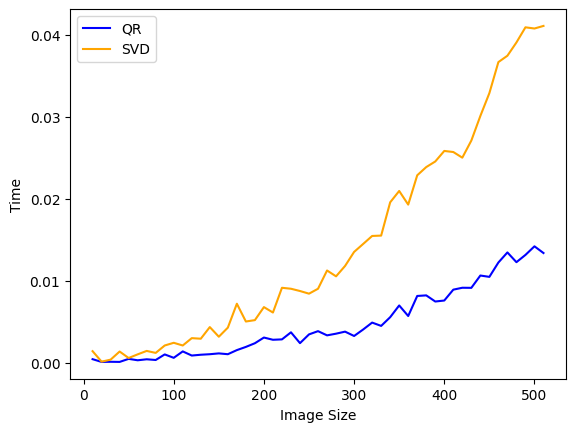

In [41]:
sizes_list = np.arange(10, 512, 10)
qr_times_list = []
svd_times_list = []

for size in sizes_list:

    img_resized = cv2.resize(img, (size, size))

    start_qr_time = time.time()
    Q, R = np.linalg.qr(img_resized)
    end_qr_time = time.time()
    qr_times_list.append(end_qr_time - start_qr_time)

    # SVD

    start_svd_time = time.time()
    U, S, Vt = np.linalg.svd(img_resized, full_matrices=False)
    end_svd_time = time.time()
    svd_times_list.append(end_svd_time - start_svd_time)

# Create a plot

# Plot the first line

pyplot.plot(sizes_list, qr_times_list, label='QR', color='blue')  # Change the color as needed


# Plot the second line

pyplot.plot(sizes_list, svd_times_list, label='SVD', color='orange')  # Change the color as needed

# Adding title and labels

pyplot.xlabel('Square Image Size (px)')

pyplot.ylabel('Time (s)')

# Show legend

pyplot.legend()

# Show the plot

pyplot.show()

